## Get image from a Lepton camera

Show it has a Gray8 (heatmap) image.

[ WARN:0@740.176] global cap_v4l.cpp:913 open VIDEOIO(V4L2:/dev/video3): can't open camera by index
[ WARN:0@740.176] global cap.cpp:478 open VIDEOIO(V4L2): backend is generally available but can't be used to capture by index


VideoCapture: True
Frame healthy? True


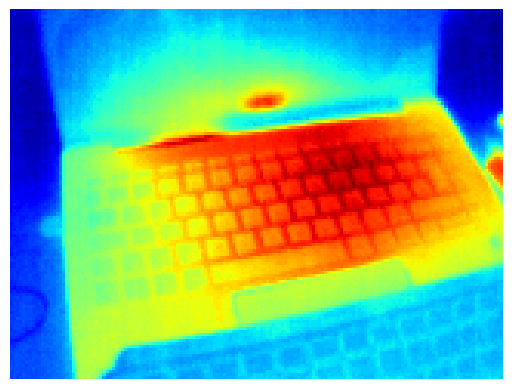

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from flirpy.camera.lepton import Lepton

with Lepton() as cam:
  cam.setup_video()
  print("VideoCapture:", cam.cap.isOpened())

  result, frame = cam.cap.read() # because cam.grap() breaks
  print("Frame healthy?", result)

  if not result:
    print("Can't receive frame (stream end?). Exiting ...")
  else:
    image = np.array(frame).reshape(-1)
    frame = image.reshape((120 + 2, 320)) # 120 + 2 for telemetry & 160 * 2

    # Gray16
    frame_16 = frame.view(np.uint16)
    frame_16 = frame_16[:-2, :]
    cv2.imwrite("lepton_frame_16.tiff", frame_16)

    # Gray8 to visualize
    norm_frame = cv2.normalize(frame_16, None, 0, 255, cv2.NORM_MINMAX)
    norm_frame = norm_frame.astype(np.uint8)
    plt.imshow(norm_frame, cmap='jet', interpolation='nearest')
    plt.axis("off")
    plt.show()

  cam.cap.release()


## Get temperature from a pixel in a Gray16 image

Gray16 image shape: (120, 160)
Pixel at (110, 50) in Gray16 image: 31107
Pixel at (110, 50) in Celsius: 37.920000000000016


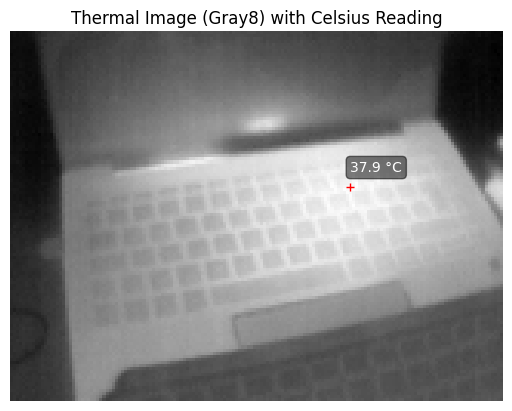

In [ ]:
import cv2

gray16_image = cv2.imread("lepton_frame_16.tiff", cv2.IMREAD_UNCHANGED)
print("Gray16 image shape:", gray16_image.shape)  # should be (120, 160)

x = 110
y = 50

# calculate the pixel value in Celsius (through the gray16 image)
pixel_value = gray16_image[y, x]
print(f"Pixel at ({x}, {y}) in Gray16 image:", pixel_value)
pixel_celsius = (pixel_value / 100) - 273.15
print(f"Pixel at ({x}, {y}) in Celsius:", pixel_celsius)

# convert the gray16 image into a gray8 to show the result
gray8_image = np.zeros((120, 160), dtype=np.uint8)
gray8_image = cv2.normalize(gray16_image, gray8_image, 0, 255, cv2.NORM_MINMAX)
gray8_image = np.uint8(gray8_image)

# plot
fig, ax = plt.subplots()
ax.imshow(gray8_image, cmap="gray")

ax.plot(x, y, "r+")
ax.text(
  x,
  y - 5,
  f"{pixel_celsius:.1f} Â°C",
  color="white",
  fontsize=10,
  bbox=dict(facecolor="black", alpha=0.5, boxstyle="round,pad=0.3"),
)

ax.set_title("Thermal Image (Gray8) with Celsius Reading")
plt.axis("off")
plt.show()